# MI2 - ES04: Kernel Principal Component Analysis
## The chantastic 4: Elisabeth Kress, Paola Suárez, Jianmeng Wu and Esra Zihni

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy.linalg as LA
from sklearn.metrics.pairwise import euclidean_distances

## 1. Kernel PCA: Toy data set

## 1.a  Create a toy data set

In [2]:
sd = 0.1
mus = np.array([[-0.5, -0.2], [0, 0.6], [0.5, 0]])
x = []
for i, mu in enumerate(mus):
    x.append(np.random.normal(mu, sd, (30,2)))
x = np.vstack(x)

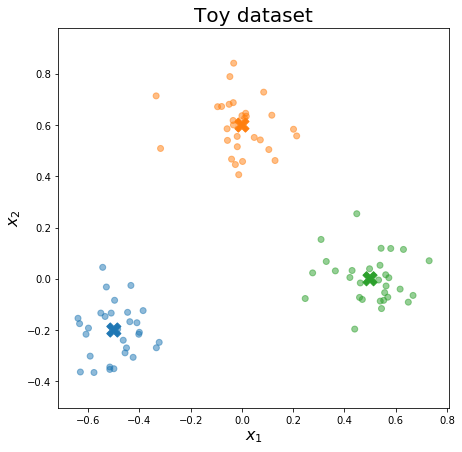

In [3]:
c = np.arange(90) // 30
colors = np.array(['C0', 'C1', 'C2'])
plt.figure(figsize=(7,7))
plt.scatter(x[:,0], x[:,1], marker='o', c=colors[c], alpha=0.5)
plt.scatter(mus[:,0], mus[:,1], marker='X', s=200, c=colors)
plt.axis('equal')
plt.title('Toy dataset', size=20)
plt.xlabel(r'$x_1$', size=16)
plt.ylabel(r'$x_2$', size=16)
plt.show()

### $x^{(\alpha)} = (x^{(\alpha)}_1,\ x^{(\alpha)}_2 ),\ \ \alpha =\ 1,\ ...,\ 90$

## 1.b Apply a Kernel PCA

In [4]:
sigma = 0.1

def rbf_kernel(x, y, sigma=sigma):
    kernel = np.exp(-np.square(euclidean_distances(x, y))/(2*np.square(sigma)))
    return kernel

In [5]:
# calculate the kernel matrix
kernel = rbf_kernel(x, x)

# Center the Kernel
kernel_centered = kernel-kernel.mean(axis=0)-kernel.mean(axis=1)+kernel.mean()

# PCA
#cov = np.cov(kernel_centered.T)
l, w = LA.eig(kernel_centered/90) # eigenvectors in columns
l = l.real
w = w.real

# sort by eigenvalues
sortedIdx = np.flipud(np.argsort(l))
w = (w.T[sortedIdx]).T # eig in columns
l = l[sortedIdx]

# normalize the eigenvectors
w_n = np.array([w[:,i]/np.sqrt(90*l[i]) for i in range(90)])
w_n = w_n.T

# normalize the eigenvalues
l_n = l/l.sum()

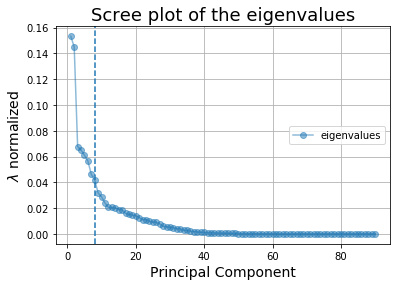

In [6]:
plt.figure()
plt.plot(np.arange(1,91), l_n, 'o-', label='eigenvalues', alpha=.5)
plt.axvline(x=8, linestyle='dashed')
#plt.plot(np.arange(1,91), np.cumsum(l_n), '.--', label='cumsum')
#plt.xlim(1, 8)
plt.title("Scree plot of the eigenvalues", size=18)
plt.xlabel("Principal Component", size=14)
plt.ylabel(r"$\lambda$ normalized", size=14)
plt.legend(loc=7)
plt.grid()
plt.show()

### $k(x^{(\alpha)}, x^{(\beta)})\ =\ exp(-\frac{\lVert {(x^{(\alpha)}- x^{(\beta)}} \rVert^2}{2\sigma^2})$

### centering: $K_{\alpha \beta}$ - row average - column average + matrix average

## 1.c Visualize the first 8 PCs

In [7]:
# create "query data" that is a meshgrid of the two dimensional input space
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
h = .005
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# predict the unseen data
# all points (px, py) on our grid in a nx2 matrix
query = np.c_[xx.ravel(), yy.ravel()]
k_query = rbf_kernel(query, x) # 29232x90
k_query_centered = ((k_query-k_query.mean(axis=0)).T-k_query.mean(axis=1)).T+k_query.mean()

# project onto the first 8 eigenvectors
w_p = w[:,:8]
Z = np.dot(w_p.T, k_query_centered.T)
Z = Z.reshape(8, xx.shape[0], xx.shape[1])

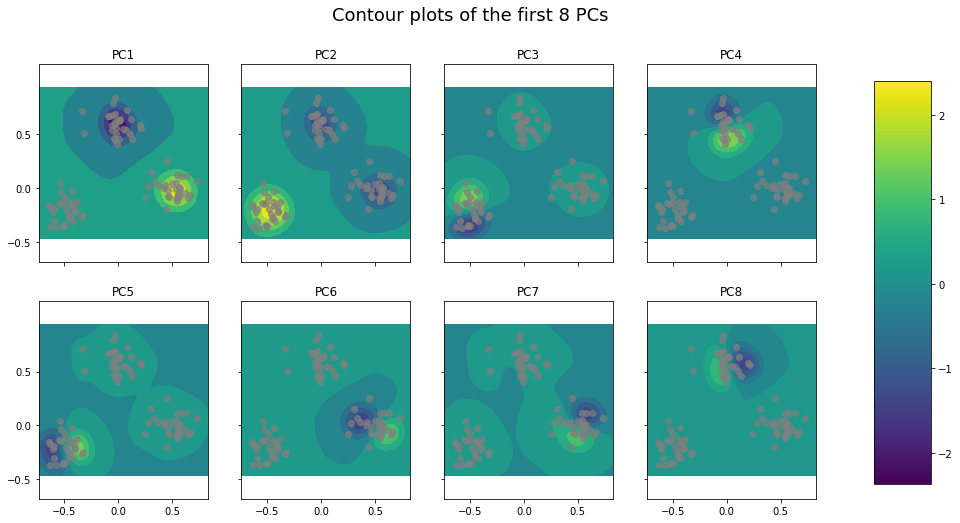

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors

vmin, vmax = Z.min(), Z.max()

fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):   
    ax.contourf(xx, yy, Z[i], vmin=vmin, vmax=vmax)
    ax.scatter(x[:, 0], x[:, 1], c='Grey', alpha=.7)
    ax.axis('equal')
    ax.set_yticks([-.5, 0, .5])
    ax.set_title('PC%d'%(i+1))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm =  colors.Normalize(vmin=vmin, vmax=vmax)
s_m =  cm.ScalarMappable(norm=norm)
s_m.set_array(np.linspace(vmin, vmax))
fig.colorbar(s_m, cax=cbar_ax)

fig.suptitle('Contour plots of the first 8 PCs', size=18)
plt.show()

#### 1. create a meshgrid containing all data points (283x324)
#### 2. calculate the kernel matrix (euclidian distances between all points on the meshgrid and the data points; 91692x90) 
#### 3. project the kernel matrix onto the first 8 PCs of the data points in the feature space (91692x90 * 90x8 = 91692x8)
#### 4. plot the contour plot for each PC

#### Interpretation:
PC1 and PC2 separate the three clusters. PC3 - PC5 divide each cluster into two halves. PC6 - PC8 divide each cluster into two halves with decision boudaries orthogonal to the ones used in PC3 - PC5.

## 1.d Discussion

- The objective of Kernel PCA is to classify non-linear data by transforming the dataset into a feature space with non-linear features. In doing so, the data now is linear in the newly defined feature space and normal methods of PCA can be appliead.

- The computational cost of the kernel PCA grows enormously with increasing size of the dataset. For instance, the kernel matrix has the size of $n^d$ if we have n data points of dimension d. In this sense, if we have larger datasets kernel PCA is not optimal. Approximations of the datasets are required for Kernel PCA.

- A Gaussian Kernel is a common transformation used for Kernel PCA, where $\sigma$ determines the spread of the Gaussian and the intensity of the weights. So, depending on the variance of your dataset, an optimal value of $\sigma$ must be chosen. This would require a grid-search using cross-validation, which also increases the computational cost. In this sense, high values of $\sigma$ will result in all the points belonging to the same cluster. Thus, for this dataset we used a the recommended value: $\sigma = 0.1$.

- Kernel PCA is suitable for feature extraction, denoising (handwritten digits, images) and dimensionality reduction.